# Simulating the recordings of an accelerometer

## Install dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative

## Problem

Given an accelerometer's movement, we want to calculate the readings of its sensors.

## Solution

It can be proven (see `./docs/draft.pdf`) that the equation governing the accelerations measured by the accelerometer are given by:

$$
\vec a'_{ni}(t) = \Omega(t) \left(\vec a_{i}(t) - \ddot{\vec R}_{i}(t) \right)
$$

where:

- $\vec a'_{ni}(t)$ is the acceleration expressed in the non-inertial coordinate frame of the accelerometer (that is, what the accelerometer registers).
- $\vec a_{i}(t)$ is the acceleration present in the outside, inertial system. Typically this corresponds to the acceleration of gravity.
- $\vec R_{i}(t)$ is the position of the non-inertial system relative to the inertial one.
- $\Omega(t)$ is the rotation matrix governing the base change from the rotated non-inertial frame respective to the inertial one.

In our notation, all vectors are column vectors. Notice also that we use the subindex $ni$ for coordinates given in the non-inertial system, and the subindex $i$ for those given in the inertial one. Last but not least, we use the notation, very common in mechanics and kinematics, of a double dot over a state to denote its second derivative, i.e.:

$$
\ddot f = \frac{d^2 f}{dt^2}
$$

### Simplified solution

Rotations are extremelly annoying. They force us to work with matrices and, even worse, with rotated coordinate systems. Fortunately, some properties of vectors are independent of the coordinates used. And acceleration is a vector.

One of this coordinate-invariant properties is the norm. The norm represents the length of the vector or, in the case of accelerations, its magnitude. The norm is a destructive operation, in the sense that all information about directionality is neglected.

It can be proven that, if we take norms at both sides of our previous equation, the following coordinate-independent relationship holds:

$$
\left\lVert \vec a'(t) \right\rVert^2 = \left\lVert \vec a(t) - \ddot{\vec R}(t) \right\rVert^2 = \left\lVert \vec a(t) \right\rVert^2 + \left\lVert \ddot{\vec R}(t) \right\rVert^2 - 2 \vec a(t) \ddot{\vec R}(t)
$$

and thus:

$$
\left\lVert \vec a'(t) \right\rVert = \sqrt{\left\lVert \vec a(t) - \ddot{\vec R}(t) \right\rVert^2} = \sqrt{\left\lVert \vec a(t) \right\rVert^2 + \left\lVert \ddot{\vec R}(t) \right\rVert^2 - 2 \vec a(t) \ddot{\vec R}(t)}
$$

## Create input

We need to define two things:

1. The world in which the accelerometer moves. This is given by the accelerations that exist on it (typically gravitation). We'll code this in the object `a`.
2. The way the accelerometer moves, given by the objects `R` (for displacement) and `omega` (for rotations).

Please note that `a` and `R` are functions of time that return column vectors, and `omega` is a function of time that returns a square matrix with the same dimensionality as the vectors (i.e.: $2 \times 2$ for plane vectors, $3 \times 3$ for spatial vectors).

### Example: rectilinear movement with uniform acceleration

In this case the corresponding displacement is:

$$
\vec R(t) = \vec R_0 + \vec v_0 t + \frac{1}{2} \vec{a_0} t^2
$$

where $\vec R_0$ is the initial position, $\vec v_0$ the initial velocity and $\vec a_0$ the constant acceleration.

The movement is rectilinear, so there is no rotation:

$$
\Omega(t) = \mathbb{I}
$$

In Python terms, we can write:

```python
def R(t, R0 = np.matrix([[0],[0]]), v0 = np.matrix([[0],[0]]), a0 = np.matrix([[0],[-9.81]])):
    return(R0 + v0 * t + 0.5 * a0 * t**2)
```

```python
def omega(t):
    return(np.identity(2))
```

### Example: uniform circular movement without frame rotation

The displacement for a circular movement is given by:

$$
\vec R(t) = R_0 \begin{bmatrix} 
                     \cos(\omega t) \\
                     \sin(\omega t)
                \end{bmatrix}
$$

where $R_0$ is the radius and $\omega$ the angular speed.

As in the example above, it there is no rotation we have $\Omega(t) = \mathbb{I}$.

In Python:

```python
def R(t, R0 = 1, w = 2*np.pi):
    return(R0 * np.matrix([[np.cos(w*t)],
                           [np.sin(w*t)]]))
```

```python
def omega(t):
    return(np.identity(2))
```

### Example: uniform circular movement with frame rotation

If our non-inertial frame of reference rotates synchronously with the displacement, the rotation matrix becomes:

$$
\Omega(t) = \begin{bmatrix}
                \cos(\omega t) & \sin(\omega t) \\
                -\sin(\omega t) & \cos(\omega t)
            \end{bmatrix}
$$

In Python:

```python
def R(t, R0 = 1, w = 2*np.pi):
    return(R0 * np.matrix([[np.cos(w*t)],
                           [np.sin(w*t)]]))
```

```python
def omega(t):
    return(np.matrix([[+np.cos(w*t), np.sin(w*t)], 
                      [-np.sin(w*t), np.cos(w*t)]]))
```

## Code it

### Install dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy.linalg import norm

### Calculate the acceleration "felt" by the accelerometer

The equation

$$
\vec a'_{ni}(t) = \Omega(t) \left(\vec a_{i}(t) - \ddot{\vec R}_{i}(t) \right)
$$

can be coded as



In [3]:
def a_ni(t, a = lambda t : np.matrix([[0], [-9.8]]),
            R = lambda t : np.matrix(([0], [0])), 
            omega = lambda t : np.identity(2)):
    '''Vectorial acceleration in the non-intertial system'''
    
    # Auxiliary functions
    def V(t, dx=1e-7, **kwargs):
        '''Numerical estimation of relative speed'''
        return(derivative(R, x0=t, dx=dx, **kwargs))

    def A(t, dx=1e-7, **kwargs):
        '''Numerical estimation of relative acceleration'''
        return(derivative(V, x0=t, dx=dx, **kwargs))
    
    # Rotate external acceleration
    rot_a = omega(t)*a(t)
    
    # Calculate and rotate relative acceleration
    rot_ni = omega(t)*A(t)
    
    # Apply formula
    return(rot_a - rot_ni)

the simplified case

$$
\left\lVert \vec a'(t) \right\rVert^2 = \left\lVert \vec a(t) - \ddot{\vec R}(t) \right\rVert^2 = \left\lVert \vec a(t) \right\rVert^2 + \left\lVert \ddot{\vec R}(t) \right\rVert^2 - 2 \vec a(t) \ddot{\vec R}(t)
$$

can be coded as:

In [4]:
def a_ni2(t, a = lambda t : np.matrix([[0], [-9.8]]),
             R = lambda t : np.matrix(([0], [0]))):
    '''Absolute acceleration in the non-intertial system'''
    
    # Auxiliary functions
    def V(t, dx=1e-7, **kwargs):
        '''Numerical estimation of relative speed'''
        return(derivative(R, x0=t, dx=dx, **kwargs))

    def A(t, dx=1e-7, **kwargs):
        '''Numerical estimation of relative acceleration'''
        return(derivative(V, x0=t, dx=dx, **kwargs))

    return(norm(a(t) - A(t)))

## Play and plot

We'll need an auxiliary function to do nice plots. Certainly this can be done in a much more elegant and efficient way using vectorization, but I am feeling to lazy to try that now.

In [5]:
def auxiliary_plotter(ts):
    # Containers for the accelerations
    asx = np.zeros(len(ts)) # In the inertial ...
    asy = np.zeros(len(ts))
    asnix = np.zeros(len(ts)) # ... and non inertial frame
    asniy = np.zeros(len(ts))

    # Loop and unpack information
    for i in range(len(ts)):
        accels = a(ts[i])
        asx[i] = accels[0]
        asy[i] = accels[1]
    
        accels_ni = a_ni(ts[i], a, R, omega)
        asnix[i] = accels_ni[0]
        asniy[i] = accels_ni[1]
        
    fig, axs = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Accelerations')

    axs[0].set_title('Inertial frame')
    axs[0].set_ylabel('accel')
    axs[0].plot(ts, asx, label = 'x')
    axs[0].plot(ts, asy, label = 'y')
    

    axs[1].set_title('Non-inertial frame')
    axs[1].plot(ts, asnix, label = 'x')
    axs[1].plot(ts, asniy, label = 'y')

    axs[0].legend()

    for ax in axs.flat:
        ax.set_xlabel('time')

## Example: rectilinear movement with uniform acceleration (free-falling object)

In this example we simulate a free-falling object, that is, a rectilinear movement with an acceleration of $(0, -g)$. We see that the measured acceleration is $0$.

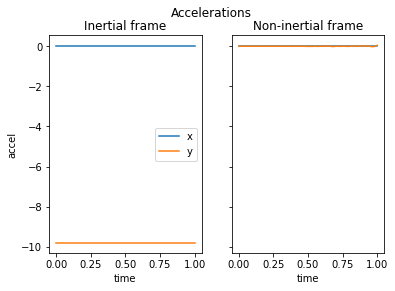

In [6]:
g = 9.81 # Acceleration of gravity (in m/s^2)

def a(t):
    '''Acceleration in the inertial system'''
    return(np.matrix([[.0], 
                      [-g]]))

def R(t, R0 = np.matrix([[0],[0]]), v0 = np.matrix([[0],[0]]), a0 = np.matrix([[0],[-g]])):
    '''Relative displacement'''  
    return(R0 + v0 * t + 0.5 * a0 * t**2)

def omega(t):
    '''Relative rotation matrix'''  
    return(np.identity(2))

# Times to plot
ts = np.linspace(0, 1) 
auxiliary_plotter(ts)

## Example: rotation in absence of gravity

In this case, we don't expect any acceleration in the inertial system, but an outwards-pointing (positive x' axis) acceleration in the rotating one (due to the centrifugal pseudoforce).

The intensity of the centrifugal acceleration in a circular movement of radius $R$ and angular speed $\omega$ is known to be:

$$
a'(t) = \omega^2 R
$$

So, with our current parameters, we expect:

$$
a'(t) \approx \left( 40, 0 \right) \frac{m}{s^2}
$$

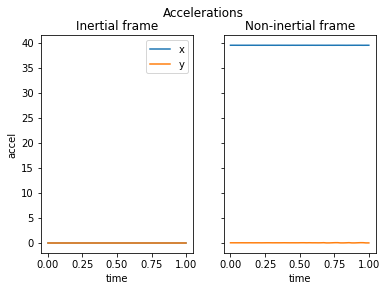

In [7]:
# Parameters
R0 = 1 # Radius of rotation
w = 2*np.pi # Angular speed

def a(t):
    '''Acceleration in the inertial system'''
    return(np.matrix([[.0], 
                      [.0]]))

def R(t):
    '''Relative displacement'''    
    return(R0 * np.matrix([[np.cos(w*t)],
                           [np.sin(w*t)]]))

def omega(t):
    '''Relative rotation matrix'''
    return(np.matrix([[+np.cos(w*t), np.sin(w*t)], 
                      [-np.sin(w*t), np.cos(w*t)]]))

# Times to plot
ts = np.linspace(0, 1)
auxiliary_plotter(ts)

## Example: rotation and gravity

The example above can be modified slightly to introduce gravity. The results start to get interesting.

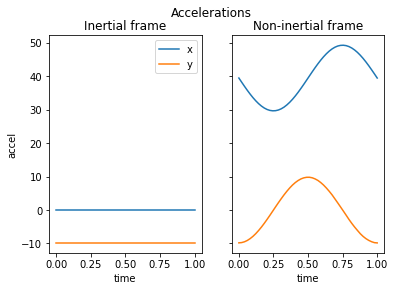

In [8]:
# Parameters
g = 9.81 # Gravitational acceleration (unsigned)
R0 = 1 # Radius of rotation
w = 2*np.pi # Angular speed

def a(t):
    '''Acceleration in the inertial system'''
    return(np.matrix([[.0], 
                      [-g]]))

def R(t):
    '''Relative displacement'''    
    return(R0 * np.matrix([[np.cos(w*t)],
                           [np.sin(w*t)]]))

def omega(t):
    '''Relative rotation matrix'''
    return(np.matrix([[+np.cos(w*t), np.sin(w*t)], 
                      [-np.sin(w*t), np.cos(w*t)]]))

# Times to plot
ts = np.linspace(0, 1)
auxiliary_plotter(ts)